In [1]:
# Step 1: Imports & basic setup

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import random
import matplotlib.pyplot as plt
from copy import deepcopy
from time import time

# for progress bars (optional, you can remove tqdm if not installed)
try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x, *args, **kwargs: x  # fallback: no progress bar

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# Step 2: Reproducibility helper

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


In [3]:
# Step 3: Data loading - Fashion-MNIST

batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))


100%|██████████| 26.4M/26.4M [00:13<00:00, 1.97MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]
100%|██████████| 4.42M/4.42M [00:02<00:00, 1.58MB/s]
100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


Train size: 60000
Test size: 10000


In [4]:
# Step 4: Model definition - same CNN with optional BatchNorm

class ConvNetBase(nn.Module):
    def __init__(self, use_bn: bool = True):
        super().__init__()
        layers = []
        layers.append(nn.Conv2d(1, 32, kernel_size=3, padding=1))
        if use_bn:
            layers.append(nn.BatchNorm2d(32))
        layers.append(nn.ReLU(inplace=True))

        layers.append(nn.Conv2d(32, 64, kernel_size=3, padding=1))
        if use_bn:
            layers.append(nn.BatchNorm2d(64))
        layers.append(nn.ReLU(inplace=True))

        layers.append(nn.MaxPool2d(2))  # 28x28 -> 14x14

        self.features = nn.Sequential(*layers)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 14 * 14, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Convenience constructors
def make_model_bn():
    return ConvNetBase(use_bn=True).to(device)

def make_model_no_bn():
    return ConvNetBase(use_bn=False).to(device)


In [5]:
# Step 5: Training and evaluation helpers

def train_one_epoch(model, optimizer, loss_fn, data_loader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in tqdm(data_loader, desc="Train", leave=False):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loss_fn, data_loader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def train_model(model, train_loader, test_loader, epochs=6, lr=0.01, seed=42):
    set_seed(seed)
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    history = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")
        t0 = time()
        tr_loss, tr_acc = train_one_epoch(model, optimizer, loss_fn, train_loader, device)
        te_loss, te_acc = evaluate(model, loss_fn, test_loader, device)
        scheduler.step()
        t1 = time()

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["test_loss"].append(te_loss)
        history["test_acc"].append(te_acc)

        print(f"  Train: loss={tr_loss:.4f}, acc={tr_acc:.4f}")
        print(f"  Test : loss={te_loss:.4f}, acc={te_acc:.4f}, time={t1 - t0:.1f}s")

    return model, history


In [6]:
# Step 6: Train the models

num_epochs = 6
base_lr = 0.01

print("\n=== Training Model A1 (CNN + BatchNorm, seed=1) ===")
model_A1 = make_model_bn()
model_A1, hist_A1 = train_model(model_A1, train_loader, test_loader,
                                epochs=num_epochs, lr=base_lr, seed=1)

print("\n=== Training Model A2 (CNN + BatchNorm, seed=2) ===")
model_A2 = make_model_bn()
model_A2, hist_A2 = train_model(model_A2, train_loader, test_loader,
                                epochs=num_epochs, lr=base_lr, seed=2)

print("\n=== Training Model B (CNN without BatchNorm, seed=3) ===")
model_B = make_model_no_bn()
model_B, hist_B = train_model(model_B, train_loader, test_loader,
                              epochs=num_epochs, lr=base_lr, seed=3)

# Optionally save the final models
torch.save(model_A1.state_dict(), "model_A1_bn.pth")
torch.save(model_A2.state_dict(), "model_A2_bn.pth")
torch.save(model_B.state_dict(),  "model_B_no_bn.pth")



=== Training Model A1 (CNN + BatchNorm, seed=1) ===

Epoch 1/6


  Train: loss=0.4005, acc=0.8562
  Test : loss=0.3108, acc=0.8881, time=25.7s

Epoch 2/6


  Train: loss=0.2554, acc=0.9058
  Test : loss=0.2771, acc=0.8982, time=35.7s

Epoch 3/6


  Train: loss=0.2140, acc=0.9204
  Test : loss=0.2656, acc=0.9057, time=35.2s

Epoch 4/6


  Train: loss=0.1437, acc=0.9475
  Test : loss=0.2200, acc=0.9211, time=24.0s

Epoch 5/6


  Train: loss=0.1321, acc=0.9523
  Test : loss=0.2221, acc=0.9199, time=14.9s

Epoch 6/6


  Train: loss=0.1248, acc=0.9553
  Test : loss=0.2172, acc=0.9225, time=14.7s

=== Training Model A2 (CNN + BatchNorm, seed=2) ===

Epoch 1/6


  Train: loss=0.3994, acc=0.8570
  Test : loss=0.3341, acc=0.8787, time=14.6s

Epoch 2/6


  Train: loss=0.2557, acc=0.9057
  Test : loss=0.2807, acc=0.9003, time=15.0s

Epoch 3/6


  Train: loss=0.2058, acc=0.9230
  Test : loss=0.2488, acc=0.9095, time=14.8s

Epoch 4/6


  Train: loss=0.1391, acc=0.9492
  Test : loss=0.2242, acc=0.9210, time=16.0s

Epoch 5/6


  Train: loss=0.1276, acc=0.9542
  Test : loss=0.2234, acc=0.9229, time=15.2s

Epoch 6/6


  Train: loss=0.1206, acc=0.9566
  Test : loss=0.2201, acc=0.9232, time=15.4s

=== Training Model B (CNN without BatchNorm, seed=3) ===

Epoch 1/6


  Train: loss=0.5552, acc=0.8033
  Test : loss=0.3877, acc=0.8584, time=15.6s

Epoch 2/6


  Train: loss=0.3239, acc=0.8840
  Test : loss=0.3212, acc=0.8842, time=15.7s

Epoch 3/6


  Train: loss=0.2769, acc=0.8992
  Test : loss=0.3175, acc=0.8867, time=15.8s

Epoch 4/6


  Train: loss=0.2276, acc=0.9181
  Test : loss=0.2727, acc=0.9000, time=15.6s

Epoch 5/6


  Train: loss=0.2202, acc=0.9205
  Test : loss=0.2663, acc=0.9012, time=15.7s

Epoch 6/6


  Train: loss=0.2158, acc=0.9219
  Test : loss=0.2651, acc=0.9015, time=15.6s


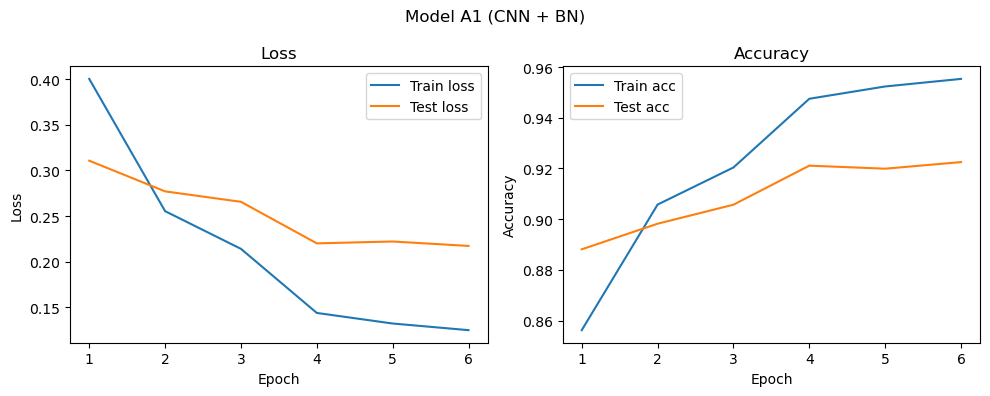

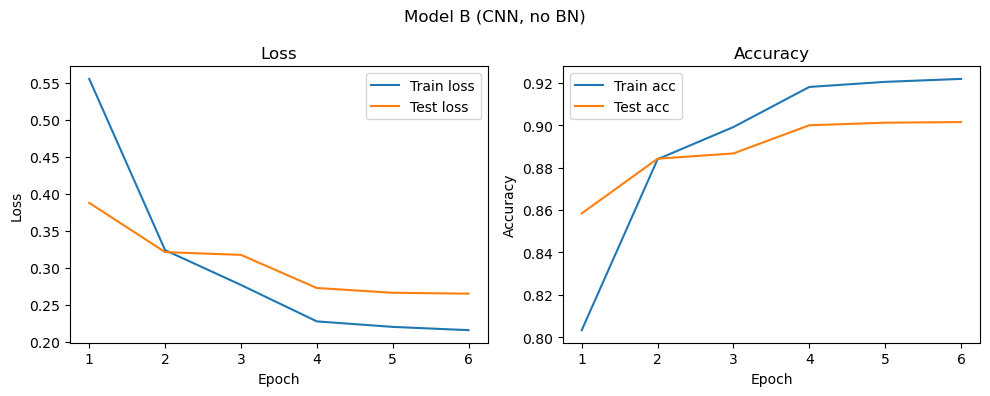

In [7]:
# Step 7: Plot training & test curves

def plot_curves(hist, title):
    epochs = range(1, len(hist["train_loss"]) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    axes[0].plot(epochs, hist["train_loss"], label="Train loss")
    axes[0].plot(epochs, hist["test_loss"], label="Test loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Loss")
    axes[0].legend()

    axes[1].plot(epochs, hist["train_acc"], label="Train acc")
    axes[1].plot(epochs, hist["test_acc"], label="Test acc")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Accuracy")
    axes[1].legend()

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_curves(hist_A1, "Model A1 (CNN + BN)")
plot_curves(hist_B,  "Model B (CNN, no BN)")


In [8]:
# Step 8: Landscape utilities: flat params, HVP, etc.

def get_flat_params(model):
    return torch.cat([p.detach().reshape(-1) for p in model.parameters()]).to(device)

def set_flat_params(model, flat_params):
    idx = 0
    for p in model.parameters():
        num = p.numel()
        p.data.copy_(flat_params[idx:idx+num].view_as(p))
        idx += num

def hvp(loss, params, v):
    grads = torch.autograd.grad(loss, params, create_graph=True)
    flat_g = torch.cat([g.reshape(-1) for g in grads])
    flat_v = torch.cat([vi.reshape(-1) for vi in v])
    gv = torch.dot(flat_g, flat_v)
    hv = torch.autograd.grad(gv, params, retain_graph=True)
    return hv

def top_eigenvalue(model, loss_fn, data_loader, device, iters=20):
    model.eval()
    params = [p for p in model.parameters() if p.requires_grad]

    inputs, targets = next(iter(data_loader))
    inputs, targets = inputs.to(device), targets.to(device)
    loss = loss_fn(model(inputs), targets)

    # initialize random vector
    v = [torch.randn_like(p) for p in params]

    # power iteration
    for _ in range(iters):
        Hv = hvp(loss, params, v)
        norm = torch.sqrt(sum((h**2).sum() for h in Hv))
        v = [h / (norm + 1e-12) for h in Hv]

    Hv = hvp(loss, params, v)
    num = sum((h * vi).sum() for h, vi in zip(Hv, v))
    den = sum((vi**2).sum() for vi in v)
    return (num / (den + 1e-12)).item()

def sharpness_sam(model, loss_fn, data_loader, device, rho=0.05):
    model.eval()
    params = [p for p in model.parameters() if p.requires_grad]

    inputs, targets = next(iter(data_loader))
    inputs, targets = inputs.to(device), targets.to(device)
    loss = loss_fn(model(inputs), targets)

    grads = torch.autograd.grad(loss, params)
    grad_norm = torch.sqrt(sum((g**2).sum() for g in grads))
    eps = [rho * g / (grad_norm + 1e-12) for g in grads]

    with torch.no_grad():
        for p, e in zip(params, eps):
            p.add_(e)

    loss_pert = loss_fn(model(inputs), targets).item()

    with torch.no_grad():
        for p, e in zip(params, eps):
            p.sub_(e)

    return loss_pert - loss.item()


In [9]:
# Step 9: Compute curvature and sharpness metrics

loss_fn = nn.CrossEntropyLoss()

print("\n=== Top eigenvalue (λ_max) and SAM sharpness ===")
lambda_A1 = top_eigenvalue(model_A1, loss_fn, train_loader, device, iters=20)
sharp_A1  = sharpness_sam(model_A1, loss_fn, train_loader, device, rho=0.05)
print(f"Model A1 (BN):   lambda_max = {lambda_A1:.4f}, SAM sharpness = {sharp_A1:.4f}")

lambda_B = top_eigenvalue(model_B, loss_fn, train_loader, device, iters=20)
sharp_B  = sharpness_sam(model_B, loss_fn, train_loader, device, rho=0.05)
print(f"Model B (no BN): lambda_max = {lambda_B:.4f}, SAM sharpness = {sharp_B:.4f}")



=== Top eigenvalue (λ_max) and SAM sharpness ===
Model A1 (BN):   lambda_max = 57.1202, SAM sharpness = 0.1037
Model B (no BN): lambda_max = 37.6186, SAM sharpness = 0.0806


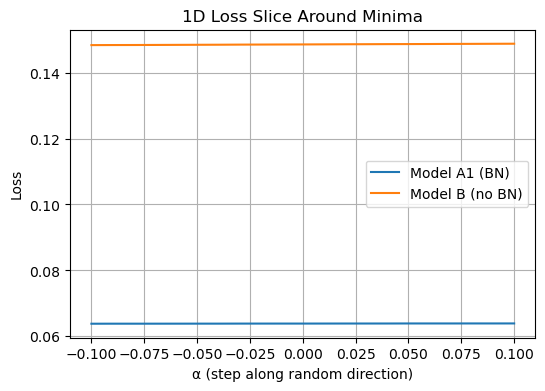

In [10]:
# Step 10: 1D loss slice around the minima

def loss_along_direction(model, loss_fn, data_loader, device, alphas, seed=0):
    set_seed(seed)
    model.eval()
    base = get_flat_params(model)
    # random direction
    direction = torch.randn_like(base)
    direction = direction / (direction.norm() + 1e-12)

    inputs, targets = next(iter(data_loader))
    inputs, targets = inputs.to(device), targets.to(device)

    losses = []
    for a in alphas:
        new_params = base + a * direction
        set_flat_params(model, new_params)
        loss = loss_fn(model(inputs), targets).item()
        losses.append(loss)

    # restore original parameters
    set_flat_params(model, base)
    return losses

alphas = torch.linspace(-0.1, 0.1, steps=21).to(device)  # small neighborhood

losses_A1 = loss_along_direction(model_A1, loss_fn, train_loader, device, alphas)
losses_B  = loss_along_direction(model_B,  loss_fn, train_loader, device, alphas)

plt.figure(figsize=(6,4))
plt.plot(alphas.cpu().numpy(), losses_A1, label="Model A1 (BN)")
plt.plot(alphas.cpu().numpy(), losses_B,  label="Model B (no BN)")
plt.xlabel("α (step along random direction)")
plt.ylabel("Loss")
plt.title("1D Loss Slice Around Minima")
plt.legend()
plt.grid(True)
plt.show()


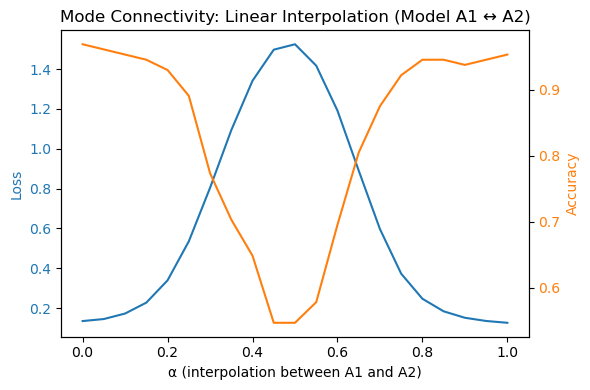

In [11]:
# Step 11: Mode connectivity (linear interpolation) between A1 and A2

def interpolate_and_eval(model_template, theta_A, theta_B, alphas, data_loader, loss_fn, device):
    # model_template: an untrained model instance of same architecture
    model = deepcopy(model_template).to(device)
    losses, accs = [], []

    inputs, targets = next(iter(data_loader))
    inputs, targets = inputs.to(device), targets.to(device)

    for a in alphas:
        flat = (1 - a) * theta_A + a * theta_B
        set_flat_params(model, flat)
        with torch.no_grad():
            outputs = model(inputs)
            loss = loss_fn(outputs, targets).item()
            preds = outputs.argmax(dim=1)
            acc = (preds == targets).float().mean().item()
        losses.append(loss)
        accs.append(acc)
    return losses, accs

# Get flat params for A1 and A2
theta_A1 = get_flat_params(model_A1)
theta_A2 = get_flat_params(model_A2)

alphas_interp = torch.linspace(0.0, 1.0, steps=21).to(device)

losses_interp, accs_interp = interpolate_and_eval(
    make_model_bn(), theta_A1, theta_A2, alphas_interp, train_loader, loss_fn, device
)

fig, ax1 = plt.subplots(figsize=(6,4))

ax1.plot(alphas_interp.cpu().numpy(), losses_interp, label="Train loss", color="tab:blue")
ax1.set_xlabel("α (interpolation between A1 and A2)")
ax1.set_ylabel("Loss", color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(alphas_interp.cpu().numpy(), accs_interp, label="Train acc", color="tab:orange")
ax2.set_ylabel("Accuracy", color="tab:orange")
ax2.tick_params(axis='y', labelcolor="tab:orange")

plt.title("Mode Connectivity: Linear Interpolation (Model A1 ↔ A2)")
fig.tight_layout()
plt.show()
